## 1. load required packages

In [1]:
import json
import os
import shutil
from glob import glob
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import PIL.Image
import pandas as pd
from rich import print
from tqdm.notebook import tqdm

## 2. download test split and show dataset statisitcs

In [2]:
# down load test patient split from chexclusion github
!wget -nc -O test.txt https://raw.githubusercontent.com/LalehSeyyed/CheXclusion/main/MIMIC/testSet_SubjID.csv

save_root = '/home/hankyul/private/cheXpert/data/classification/chest/mimic-cxr/'
img_path_list = glob(os.path.join(save_root, 'files', '*', '*', '*.jpg'))
csv_path_list = glob(os.path.join(save_root, '*.csv'))
csv_list = []

for csv_path in csv_path_list:
    csv_list.append(pd.read_csv(csv_path))

with open('test.txt', 'rt') as f:
    test_patient_ids = [x.strip('\n') for x in f.readlines()]

print(f"len of total image: {len(img_path_list)}")
print(f"example image path:")
print(img_path_list[:5])
print(f"csv list:")
print(csv_path_list)
print(f"len of test patient id: {len(test_patient_ids)}")
print(f"exmple patient id:")
print(test_patient_ids[:5])

File ‘test.txt’ already there; not retrieving.


len of total image: 377110

example image path:

[
    '/home/hankyul/private/cheXpert/data/classification/chest/mimic-cxr/files/p16603653/s5408
6082/f5ff966c-c6ee100c-3383597b-27e91767-9f45cfd9.jpg',
    '/home/hankyul/private/cheXpert/data/classification/chest/mimic-cxr/files/p16603653/s5408
6082/f9a9714b-2ca35e1d-c32c21ee-d6f5b26f-84213801.jpg',
    '/home/hankyul/private/cheXpert/data/classification/chest/mimic-cxr/files/p16603653/s5552
2730/76778ab1-0724a699-a36bb0bf-409e904c-5d9b9ed2.jpg',
    '/home/hankyul/private/cheXpert/data/classification/chest/mimic-cxr/files/p16603653/s5552
2730/ed155878-a4b6213d-5be28c05-c8a5f03c-39929c58.jpg',
    '/home/hankyul/private/cheXpert/data/classification/chest/mimic-cxr/files/p16603653/s5817
0877/c5bd35a0-65587616-b2f6a2ff-3ce95db7-bec18f4b.jpg'
]

csv list:

[
    '/home/hankyul/private/cheXpert/data/classification/chest/mimic-cxr/mimic-cxr-2.0.0-metad
ata.csv',
    '/home/hankyul/private/cheXpert/data/classification/chest/mimic-cxr/mimic-cxr-2.0.0-chexp
ert.csv',
    '/home/hankyul/private/cheXpert/data/classification/chest/mimic-cxr/mimic-cxr-2.0.0-negbi
o.csv',
    '/home/hankyul/private/cheXpert/data/classification/chest/mimic-cxr/mimic-cxr-2.0.0-split
.csv'
]

len of test patient id: 36421

exmple patient id:

['10002559', '10002559', '10002559', '10002559', '10002559']

## 3. select label csv

In [3]:
label_csv = csv_list[2]

print(f'len of label: {len(label_csv)}')
print(f"len of subject: {len(label_csv['subject_id'].unique())}")
label_csv.replace(-1, 0, inplace=True)
label_csv.fillna(0, inplace=True)
label_csv.set_index(['subject_id', 'study_id'], inplace=True)
label_csv.head()

len of label: 227827

len of subject: 65379

Atelectasis  Cardiomegaly  Consolidation  Edema  \
subject_id study_id                                                    
10000032   50414267          0.0           0.0            0.0    0.0   
           53189527          0.0           0.0            0.0    0.0   
           53911762          0.0           0.0            0.0    0.0   
           56699142          0.0           0.0            0.0    0.0   
10000764   57375967          0.0           0.0            1.0    0.0   

                     Enlarged Cardiomediastinum  Fracture  Lung Lesion  \
subject_id study_id                                                      
10000032   50414267                         0.0       0.0          0.0   
           53189527                         0.0       0.0          0.0   
           53911762                         0.0       0.0          0.0   
           56699142                         0.0       0.0          0.0   
10000764   57375967                         0.0       0.0          0.0   

                     Lung Opacity  No Finding  Pleural Effusion  \
subject_id study_id                                               
10000032   50414267           0.0         1.0               0.0   
           53189527           0.0         1.0               0.0   
           53911762           0.0         1.0               0.0   
           56699142           0.0         1.0               0.0   
10000764   57375967           0.0         0.0               0.0   

                     Pleural Other  Pneumonia  Pneumothorax  Support Devices  
subject_id study_id                                                           
10000032   50414267            0.0        0.0           0.0              0.0  
           53189527            0.0        0.0           0.0              0.0  
           53911762            0.0        0.0           0.0              0.0  
           56699142            0.0        0.0           0.0              0.0  
10000764   57375967            0.0        0.0           0.0              0.0

## 4. split dataset into train/test

In [ ]:
train_x = []
train_y = []
test_x = []
test_y = []
prog_bar = tqdm(img_path_list)
i = 0
for img_path in prog_bar:
    img_path_split = img_path.split('/')
    img_path_sub = '/'.join(img_path_split[-3:])
    sub_id, study_id = [x[1:] for x in img_path_split[-3:-1]]
    try:
        label = label_csv.loc[(int(sub_id), int(study_id))].tolist()
    except:
        print(f"{img_path} does not have the label")
        continue
    
    if sub_id in test_patient_ids:
        test_x.append(img_path_sub)
        test_y.append(label)
    else:
        train_x.append(img_path_sub)
        train_y.append(label)
        
    if i % 50 == 0:
        prog_bar.set_description(f"train:{len(train_x)} | test:{len(test_x)}")
    i+= 1
print(f'len of train split: {len(train_x)}')
print(f'len of test split: {len(test_x)}')

## 5. show label distribution per train / test split 

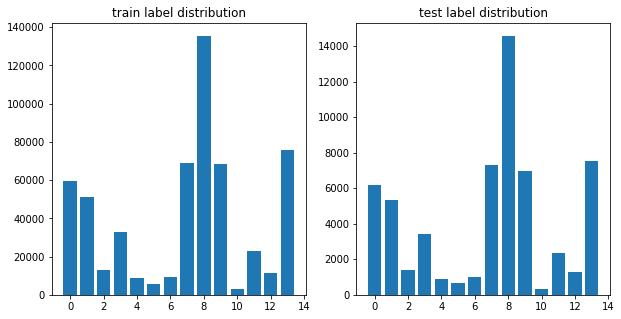

In [31]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(list(range(14)), np.array(train_y).sum(axis=0))
plt.gca().set_title('train label distribution')
plt.subplot(1, 2, 2)
plt.bar(list(range(14)), np.array(test_y).sum(axis=0))
plt.gca().set_title('test label distribution')
plt.show()

## 6. save label per each split

In [ ]:
with open(os.path.join(save_root, 'train_x.json'), 'wt') as f:
    json.dump(train_x, f, ensure_ascii=False, indent=4)

with open(os.path.join(save_root, 'train_y.json'), 'wt') as f:
    json.dump(train_y, f, ensure_ascii=False, indent=4)
    
with open(os.path.join(save_root, 'test_x.json'), 'wt') as f:
    json.dump(test_x, f, ensure_ascii=False, indent=4)
    
with open(os.path.join(save_root, 'test_y.json'), 'wt') as f:
    json.dump(test_y, f, ensure_ascii=False, indent=4)